In [1]:
from common_imports import *
from helper import *

# To plot pretty figures
%matplotlib widget

Using TensorFlow backend.


1.13.1


### Train a DNN on the modified dataset

In [29]:
# Get split returns a generator
# List comprehension is one way to evaluate a generator

original_data, modded_samples, training_labels, original_labels = simulate_blobs(class_size=3000)

# Separating a hold out set that will be used for validation later
X_train, y_train, X_test, y_test, y_original, X_valid, y_valid, y_valid_original = get_train_test_val(modded_samples, original_labels, training_labels)


print("Train Size:", X_train.shape)
print("Test Size:", y_test.shape)


hot_encoder = dfHotEncoder()
hot_encoder.fit(training_labels)
print("Categories:", hot_encoder.categories_)

Creating data...


FigureCanvasNbAgg()

Train Size: (2700, 2)
Test Size: (300,)
Categories: [array([0, 1])]


In [30]:
NUM_FEATURES = X_train.shape[1]
NUM_LABELS = len(hot_encoder.categories_[0])

In [31]:
def build_dnn(num_features, num_labels=3):

#     reset_graph()
    
    keras.backend.clear_session()

    nn = keras.models.Sequential()
    Dense = keras.layers.Dense
    
    # Using He initialization
    he_init = tf.keras.initializers.he_uniform()
    
    nn.add(Dense(units = 16, activation="elu", input_dim=num_features,
                kernel_initializer=he_init))
    nn.add(Dense(units = 16, activation="elu",
                kernel_initializer=he_init))
#     nn.add(Dense(units = 16, activation="elu",
#                 kernel_initializer=he_init))
    nn.add(Dense(units=2, activation= "softmax",
                kernel_initializer=he_init))

#     BCE = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    
    nn.compile(loss="categorical_crossentropy",
                  optimizer='sgd',
                  metrics=['accuracy'])
    
    return nn

def train_model(model, X, y, X_test=[], y_test=[], epochs=30, batch_size=20, verbose=1, plot=True):
    
    ZScaler = StandardScaler().fit(X)
    
    X_train = ZScaler.transform(X)
    X_test = ZScaler.transform(X_test)
    
    y_train = hot_encoder.transform(y)
    y_test = hot_encoder.transform(y_test)
    
#     lr_scheduler = keras.callbacks.LearningRateScheduler(exp_decay)
    callback_list = []
    
    history = model.fit(X_train, y_train, epochs=epochs, batch_size = batch_size,
                        validation_data=(X_test, y_test), callbacks=callback_list, verbose=verbose)
    
#     if plot: plot_history(history)
    
    return history, ZScaler


In [87]:
nn = build_dnn(NUM_FEATURES)
%time history, Zscaler = train_model(nn, X_train, y_train, X_test, y_test, epochs=50, batch_size=20)

Train on 2700 samples, validate on 300 samples
Epoch 1/50
2700/2700 [==============================] - 0s 88us/step - loss: 0.4018 - acc: 0.9156 - val_loss: 0.1616 - val_acc: 1.0000
Epoch 2/50
2700/2700 [==============================] - 0s 37us/step - loss: 0.1127 - acc: 1.0000 - val_loss: 0.0746 - val_acc: 1.0000
Epoch 3/50
2700/2700 [==============================] - 0s 33us/step - loss: 0.0605 - acc: 1.0000 - val_loss: 0.0457 - val_acc: 1.0000
Epoch 4/50
2700/2700 [==============================] - 0s 33us/step - loss: 0.0398 - acc: 1.0000 - val_loss: 0.0321 - val_acc: 1.0000
Epoch 5/50
2700/2700 [==============================] - 0s 35us/step - loss: 0.0291 - acc: 1.0000 - val_loss: 0.0245 - val_acc: 1.0000
Epoch 6/50
2700/2700 [==============================] - 0s 33us/step - loss: 0.0226 - acc: 1.0000 - val_loss: 0.0196 - val_acc: 1.0000
Epoch 7/50
2700/2700 [==============================] - 0s 34us/step - loss: 0.0184 - acc: 1.0000 - val_loss: 0.0163 - val_acc: 1.0000
Epoch 8/

In [88]:
# Plotting results from history
plot_history(history)

FigureCanvasNbAgg()

In [89]:
preds = [x for x in nn.predict(Zscaler.transform(X_test[:5]))]
_labels = [np.float(x) for x in y_test]
preds[:5],_labels[:5]

([array([0.998968  , 0.00103205], dtype=float32),
  array([7.1029417e-04, 9.9928963e-01], dtype=float32),
  array([0.00129831, 0.9987017 ], dtype=float32),
  array([9.9999976e-01, 2.7299623e-07], dtype=float32),
  array([0.00338153, 0.9966184 ], dtype=float32)],
 [0.0, 1.0, 1.0, 0.0, 1.0])

## Performing SVM on Modded Samples

In [90]:
from sklearn.svm import LinearSVC

svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("SVM", LinearSVC(C=1, loss="hinge", max_iter=1000 ))
])

%time svm_clf.fit(X_train, y_train)
print("Linear SVM Test Accuracy: {:0.3f}".format(svm_clf.score(X_test, y_test)))

CPU times: user 4.94 ms, sys: 1.25 ms, total: 6.19 ms
Wall time: 4.98 ms
Linear SVM Test Accuracy: 0.687


/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## Performing LRP

In [91]:
import innvestigate
import innvestigate.utils as iutils

def perform_analysis(model, analyzer, data, labels=[]):
    analysis = analyzer.analyze(data)
    prediction = model.predict(data)
    
    df_anal = pd.DataFrame(analysis)
    
    return df_anal


scaled_samples = Zscaler.transform(X_valid)

# Getting all the samples that can be correctly predicted
all_samples, _labels, correct_idxs = getCorrectPredictions(nn, scaled_samples, y_valid, enc = hot_encoder)
all_labels = y_valid_original[correct_idxs]


# Stripping the softmax activation from the model
model_w_softmax = nn
model = iutils.keras.graph.model_wo_softmax(model_w_softmax)

# Creating an analyzer
lrp_E = innvestigate.analyzer.relevance_based.relevance_analyzer.LRPEpsilon(model=model, epsilon=1e-3)
# lrp_Z = innvestigate.analyzer.relevance_based.relevance_analyzer.LRPZPlus(model=model)
# lrp_AB   = innvestigate.analyzer.relevance_based.relevance_analyzer.LRPAlpha2Beta1(model=model)

all_lrp_E = perform_analysis(model,lrp_E, all_samples)

Prediction Accuracy
3000/3000 [==============================] - 0s 11us/step
Scores on data set: loss=0.002 accuracy=1.0000


In [92]:
all_labels.value_counts()

4    1500
7     188
5     188
3     188
2     188
1     187
8     187
6     187
0     187
Name: label, dtype: int64

In [93]:
plt.close("Comparison")
fig, axs = plt.subplots(1,2, figsize=(20,10), num="Comparison")
cmap = "Set1" #"Paired"
plot_args = {"kind":"scatter", "x":0,  "y":1, "c":"label", "cmap": cmap, "s":10, "alpha":0.25}

original_data.plot(ax=axs[0],title="Original Distribution", **plot_args)

plot_args["c"] = all_labels
all_lrp_E.plot(ax=axs[1], title="LRP E", **plot_args)


plt.tight_layout()
plt.show()
# plt.savefig(figures_dir+"multiclass_lrp.png")

FigureCanvasNbAgg()

In [94]:
plt.close("Positive Only LRP")
fig, axs = plt.subplots(1,3, figsize=(18,6), num="Positive Only LRP")

plot_args["c"] = "label"
original_data.plot(ax=axs[0], title="Original Distribution", **plot_args)

plot_args["c"] = all_labels
all_lrp_E.plot(ax=axs[1], title="LRP E", **plot_args)

pos_lrp = all_lrp_E.copy()
pos_lrp[pos_lrp<0] = 0
pos_lrp["label"] = all_labels.values
pos_lrp.plot(ax=axs[2],title="LRP E", **plot_args)

plt.tight_layout()
plt.show()

FigureCanvasNbAgg()

In [95]:
plotSeparatedLRP(pos_lrp)

FigureCanvasNbAgg()

# Beginning Clustering using accelerated HDBSCAN*

In [116]:
import hdbscan
import seaborn as sns
%matplotlib inline
# sns.set_context('poster')
# sns.set_style('white')
plt.rcParams['axes.titlesize'] = 16
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

In [117]:
y_valid_original.value_counts()

4    1500
7     188
5     188
3     188
2     188
1     187
8     187
6     187
0     187
Name: label, dtype: int64

In [118]:
# cluster_labels.value_counts()

# Comparing Different Minimum Cluster Size

In [119]:
from sklearn import metrics

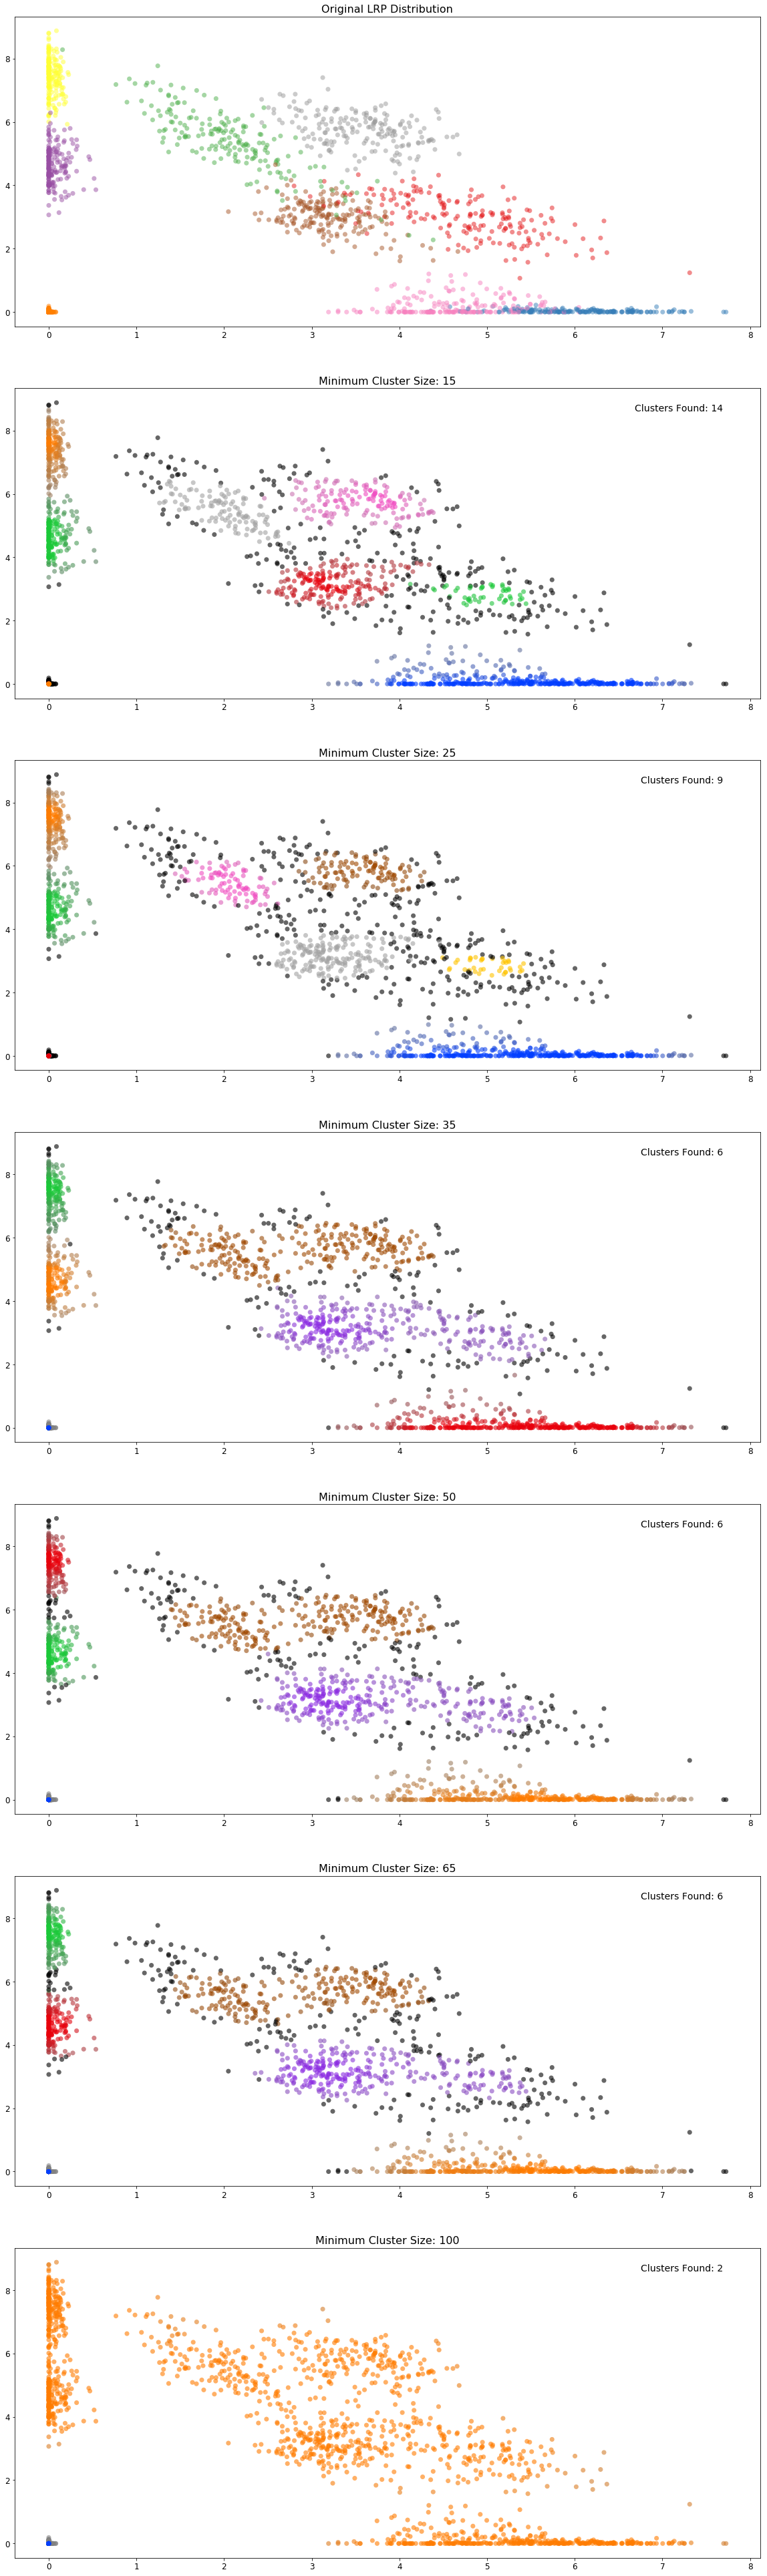

In [129]:
data = pos_lrp[[0,1]].values

cluster_sizes = [15,25,35,50,65,100]
plt.close("Cluster Comparison")
fig, axs = plt.subplots(1+len(cluster_sizes), 1, figsize=(20,10*(1+len(cluster_sizes))), num="Cluster Comparison")
plt.title("Cluster Comparison")


axs[0].scatter(*data.T, s=50, linewidth=0, c=pos_lrp["label"].values, alpha=0.5, cmap=plot_args["cmap"])
axs[0].set_title("Original LRP Distribution")


_metrics = []

for i,size in enumerate(cluster_sizes):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=size)
    clusterer.fit(data)
    cluster_labels = clusterer.labels_
    
     ## Number of clusters in labels, ignoring noise if present.
    num_clusters = cluster_labels.max() + 1
    
    color_palette = sns.color_palette("bright", num_clusters)
    cluster_colors = [color_palette[x] if x >= 0
                      else (0, 0, 0)
                      for x in clusterer.labels_]
    cluster_member_colors = [sns.desaturate(x, p) for x, p in
                             zip(cluster_colors, clusterer.probabilities_)]
    
    
#     _, ymax = axs[i+1].get_ylim()
#     _, xmax = axs[i+1].get_xlim()
    
   
    noise = list(cluster_labels).count(-1)/len(cluster_labels)
    hscore,cscore,vscore = metrics.homogeneity_completeness_v_measure(y_valid_original, cluster_labels)
    sil_score = metrics.silhouette_score(data, cluster_labels, metric="euclidean")
    
    _metrics.append([num_clusters,noise,sil_score,hscore,cscore,vscore])
    
    
    axs[i+1].scatter(*data.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.6)
    axs[i+1].set_title("Minimum Cluster Size: {}".format(size))
    axs[i+1].text(0.95,0.95,"Clusters Found: {}".format(num_clusters),
                horizontalalignment='right', verticalalignment='top',
                fontsize=14, transform=axs[i+1].transAxes)

# plt.tight_layout()
plt.show()

In [130]:
# plt.savefig(figures_dir+"cluster_graph_comparison.png")

In [131]:
## Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
noise = list(cluster_labels).count(-1)/len(cluster_labels) * 100

hscore,cscore,vscore = metrics.homogeneity_completeness_v_measure(y_valid_original, cluster_labels)
sil_score = metrics.silhouette_score(data, cluster_labels, metric="euclidean")

print("Noise: {:7}{:.2f}%".format("",noise))
print("Homogeneity:  {:.3f}\nCompleteness: {:.3f}\nV-Measure:    {:.3f}".format(hscore, cscore, vscore))
print("Silhouette: {:2}{:.3f}".format("",sil_score))

Noise:        0.00%
Homogeneity:  0.400
Completeness: 1.000
V-Measure:    0.571
Silhouette:   0.639


# Plotting Performance Metrics

In [132]:
scores = pd.DataFrame(_metrics, columns=["Clusters", "Noise", "Silhouette", "Homogeneity", "Completeness", "V-Measure"], index=cluster_sizes)
scores

,Clusters,Noise,Silhouette,Homogeneity,Completeness,V-Measure
15,14,0.152333,0.543549,0.790638,0.689912,0.736848
25,9,0.168333,0.534939,0.768176,0.741189,0.754441
35,6,0.056667,0.752217,0.803114,0.888792,0.843784
50,6,0.071000,0.742112,0.791561,0.874407,0.830924
65,6,0.082000,0.734443,0.787714,0.868726,0.826239
100,2,0.000000,0.638533,0.400000,1.000000,0.571429


/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/pandas/plotting/_core.py:1801: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x146982d30>,
      dtype=object)

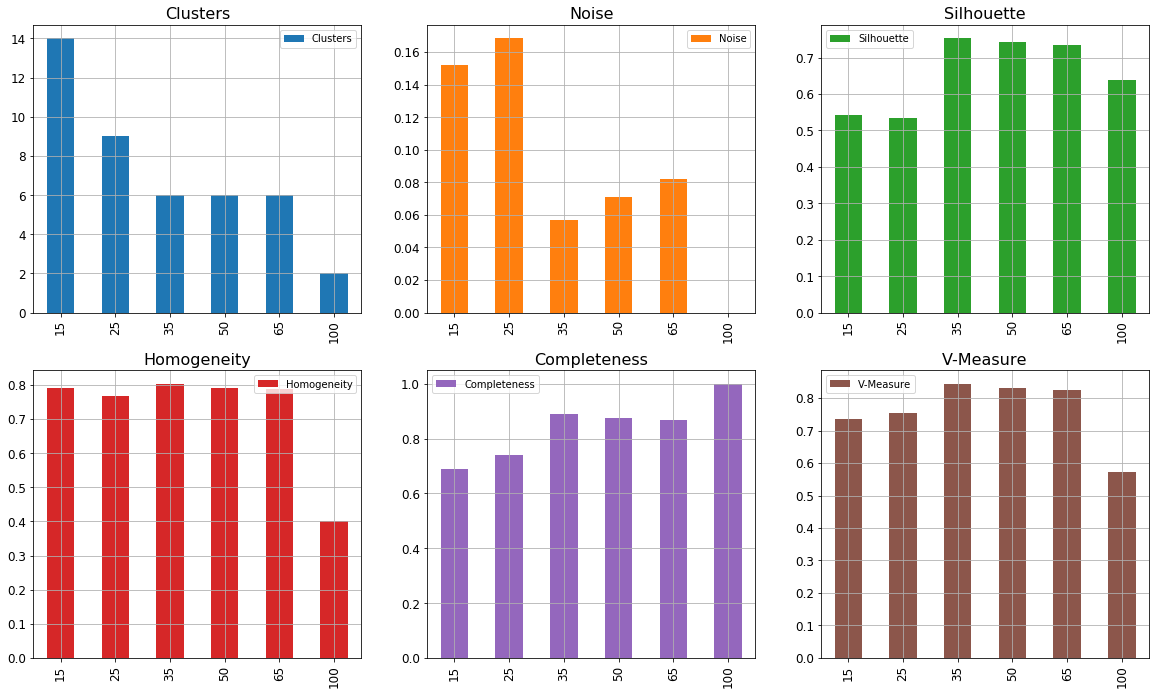

In [133]:
plt.close("Cluster Scores")
fig, axs = plt.subplots(figsize=(20,18), num="Cluster Scores")
plt.title("Cluster Scores")
scores.plot(kind="bar", ax=axs, subplots=True, layout=(3,3), grid = True)

In [134]:
# plt.savefig(figures_dir+"cluster_score.png")

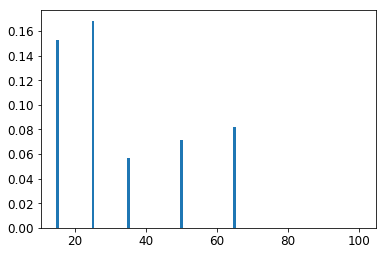

In [127]:
plt.bar(scores.index.values,scores["Noise"].values)
plt.show()

In [80]:
plt.close("Scores")
fig, axs = plt.subplots(3,3,figsize=(15,15), num="Scores")
scores["V-Measure"].plot(ax=axs[0][1], kind="bar", logy=True)
axs[1][1].bar(scores.index.values,scores["Noise"].values, log=True)
axs[1][1].tick_params(axis='y', which='minor')

FigureCanvasNbAgg()